In [1]:
import nest
import numpy as np
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from utils.extractors import filter_spikes_parallel
import scipy


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.2
 Built: Mar 29 2023 08:43:05

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
nest.ResetKernel()
dt = .1
duration = 3000 #ms
#nest.resolution = 1.0
# Parameters
nEnc = 500  # number of neurons in the encoding layer
J_bias = 200. # [pA] 
tuning = 250. * np.random.randn(nEnc) + 1000.


Text(0, 0.5, 'Amplitude')

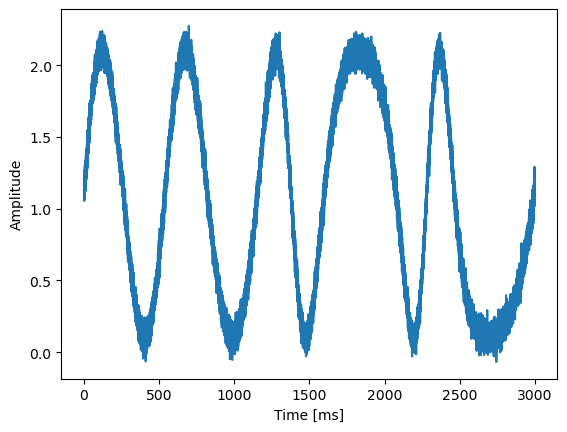

In [3]:
t_samples = np.arange(-100, 3500, 300)
freq_samples = (np.random.random(t_samples.shape) * 1.5 + 0.5)/100

t = np.arange(0, duration, dt)+dt

dx = np.full_like(t, dt)       # Change in x

interpolation = scipy.interpolate.interp1d(t_samples, freq_samples, kind='quadratic')
freq = interpolation(t)

x = (freq * dx ).cumsum()    # Cumsum freq * change in x
noise = np.random.normal(loc=0, scale=0.05, size=x.shape)  # loc=mean, scale=stddev

signal_gt = np.sin(x)+1+dt 
signal = np.sin(x)+1+dt+noise

pl.plot(t, signal)
pl.xlabel('Time [ms]')
pl.ylabel("Amplitude")


In [4]:
print(len(signal))

30000


In [5]:
print(len(t))

30000


In [6]:
thresholds = 5 * np.random.randn(nEnc) - 50.
Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc)))

In [7]:
enc_layer = nest.Create('iaf_psc_delta', nEnc, {'I_e': J_bias})

In [8]:
step_generator = nest.Create('step_current_generator', nEnc)
amplitudes = np.zeros((nEnc, len(signal)))
for n in range(nEnc):
    amplitudes[n, :] = signal * tuning[n]
    enc_layer[n].set({'V_m': Vm0[n], 'V_th': thresholds[n]})
    #print(len(amplitudes[0]), len(t))
    step_generator[n].set({'amplitude_times': t, 'amplitude_values': amplitudes[n]})
    nest.Connect(step_generator[n], enc_layer[n])

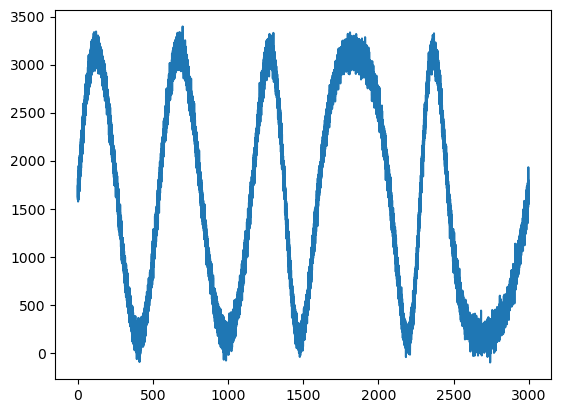

In [9]:
pl.plot(t, amplitudes[0])

In [10]:
len(amplitudes[0])

30000

In [11]:
enc_spks = nest.Create('spike_recorder')
nest.Connect(enc_layer, enc_spks)


In [12]:
#### PARAMETERS ###
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 200                  # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# create spike detectors
spikes_e = nest.Create('spike_recorder')
# E synapses
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

# spike detector
nest.Connect(neurons_e, spikes_e)

In [13]:
nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)

In [14]:
nest.Simulate(len(t))


Oct 21 18:13:35 NodeManager::prepare_nodes [Info]: 
    Preparing 2252 nodes for simulation.

Oct 21 18:13:35 MUSICManager::enter_runtime [Info]: 
    Entering MUSIC runtime with tick = 1 ms

Oct 21 18:13:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2252
    Simulation time (ms): 30000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Oct 21 18:14:43 SimulationManager::run [Info]: 
    Simulation finished.


In [15]:
#this filters the spikes from the encoding layer 
filter_tau = 20. # [ms]
num_threads = 8
t_stop = len(t)/10

enc_activity = enc_spks.events
enc_states = filter_spikes_parallel(enc_activity['times'], enc_activity['senders'], nEnc, t_start=0., 
                                    t_stop=t_stop, dt=dt, tau=filter_tau, n_processes=num_threads)


e_activity = spikes_e.events
# e_states = filter_spikes(e_activity['times'], e_activity['senders'], NE, t_start=0., t_stop=T*duration, dt=dt, tau=filter_tau)

# if you can use parallelization, it can be very useful here:
e_states = filter_spikes_parallel(e_activity['times'], e_activity['senders'], NE, t_start=0., t_stop=t_stop, 
                                  dt=dt, tau=filter_tau, n_processes=num_threads)

Filtering SpikeTrains: 100%|████████████████████████████████████████████████████████| 1000/1000 [01:13<00:00, 13.65it/s]


In [16]:
def compute_capacity(x, z):
    """
    Compute capacity to reconstruct z based on linearly combining x

    Parameters
    ----------
    x : np.ndarray
        state matrix(NxT)
    z : np.ndarray
        target output (1xT)

    Returns
    -------
    z_hat : np.ndarray
        Reconstructed (predicted) signal

    """
    reg = LinearRegression(n_jobs=-1, fit_intercept=False).fit(x.T, z)
    W_out = reg.coef_
    z_hat = np.dot(W_out, x)

    covs = np.cov(z_hat, z)[0, 1] ** 2.0
    vars = np.var(z) * np.var(z_hat)
    capacity = covs / vars

    error = np.mean((z - z_hat) ** 2)
    return z_hat, capacity, error

enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, signal_gt)
circ_estimate, circ_capacity, circ_error = compute_capacity(e_states, signal_gt)

print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))

Encoding Layer: 
	- Capacity=0.9594179960505834, MSE=0.021389624908201288
Main Circuit: 
	- Capacity=0.9707342761368013, MSE=0.02227511032860485


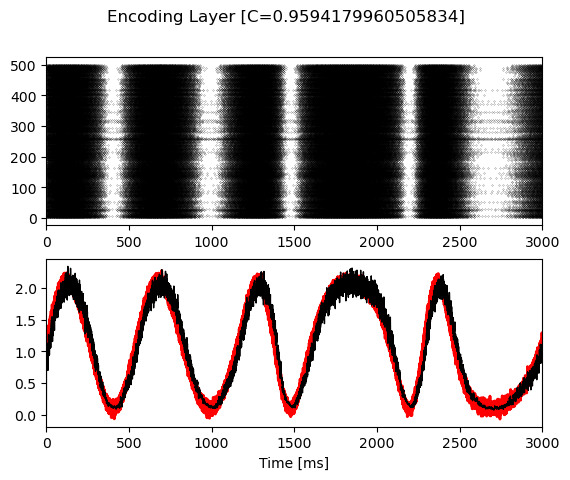

In [17]:
fig = pl.figure()
fig.suptitle('Encoding Layer [C={0}]'.format(str(enc_capacity)))
ax11 = fig.add_subplot(211)
ax12 = fig.add_subplot(212, sharex=ax11)
ax11.plot(enc_activity['times'], enc_activity['senders'], '.k', markersize=0.3)
ax11.set_xlim([0., len(t)/10])
ax12.plot(t, signal, 'r', linewidth=2)
ax12.plot(t, enc_estimate, 'k', linewidth=1)
ax12.set_xlabel(r'Time [ms]')
pl.show()

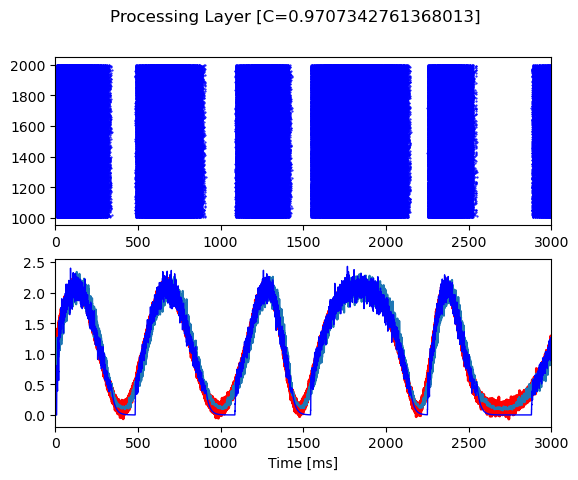

In [18]:
fig = pl.figure()
fig.suptitle('Processing Layer [C={0}]'.format(str(circ_capacity)))
ax11 = fig.add_subplot(211)
ax12 = fig.add_subplot(212, sharex=ax11)
ax11.plot(e_activity['times'], e_activity['senders'], '.b', markersize=1)
ax11.set_xlim([0., len(t)/10])
ax12.plot(t, signal, 'r', linewidth=2)
ax12.plot(t, enc_estimate)
ax12.plot(t, circ_estimate, 'b', linewidth=1)
ax12.set_xlabel(r'Time [ms]')
pl.show()

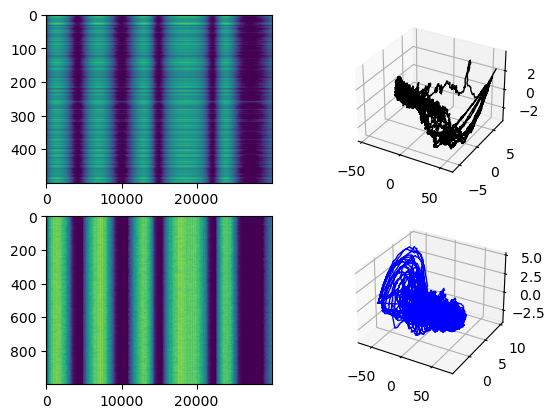

In [19]:
fig = pl.figure()
ax1 = fig.add_subplot(221)
ax1.imshow(enc_states, aspect='auto')
ax2 = fig.add_subplot(222, projection='3d')
pca_fit_enc = PCA(n_components=np.shape(enc_states)[0])
X_enc = pca_fit_enc.fit_transform(enc_states.T)
ax2.plot(X_enc[:, 0], X_enc[:, 1], X_enc[:, 2], color='k', lw=1)
ax3 = fig.add_subplot(223)
ax3.imshow(e_states, aspect='auto')
ax4 = fig.add_subplot(224, projection='3d')
pca_fit_enc = PCA(n_components=np.shape(e_states)[0])
X_cir = pca_fit_enc.fit_transform(e_states.T)
ax4.plot(X_cir[:, 0], X_cir[:, 1], X_cir[:, 2], color='b', lw=1)
pl.show()

Lag = 0.1 ms
Encoding Layer: 
	- Capacity=0.9551768129802809, MSE=0.02374915321561961
Main Circuit: 
	- Capacity=0.9661647619416007, MSE=0.02482394149270119
Lag = 10.1 ms
Encoding Layer: 
	- Capacity=0.9838149505150287, MSE=0.008626846478204922
Main Circuit: 
	- Capacity=0.9807572986768845, MSE=0.015060834691762061
Lag = 20.1 ms
Encoding Layer: 
	- Capacity=0.9926739240528167, MSE=0.003935049839092828
Main Circuit: 
	- Capacity=0.985462962659775, MSE=0.01184004492930701
Lag = 30.1 ms
Encoding Layer: 
	- Capacity=0.9808201201735023, MSE=0.010273457590938003
Main Circuit: 
	- Capacity=0.9851853645076616, MSE=0.011929793378486344
Lag = 40.1 ms
Encoding Layer: 
	- Capacity=0.9497989543299263, MSE=0.026915347875810524
Main Circuit: 
	- Capacity=0.9813240223979214, MSE=0.014454982689709676
Lag = 50.1 ms
Encoding Layer: 
	- Capacity=0.9019166619634743, MSE=0.05270635591526956
Main Circuit: 
	- Capacity=0.973662505916864, MSE=0.019575449932864357
Lag = 60.1 ms
Encoding Layer: 
	- Capacity=0.84

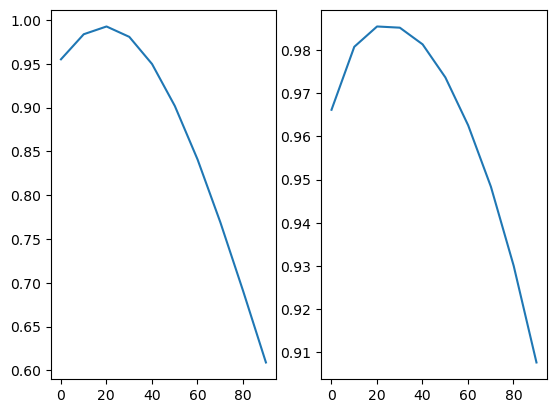

Total capacity (encoder): 86.73571829809907 ms
Total capacity (processor): 96.21086074447669 ms


In [20]:
max_lag = 100.  # [ms] in this example
step_lag = 10  # [ms] - if != dt (index the time axis)
time_lags = np.arange(0., max_lag, step_lag)+dt
indices = [np.where(idx == t)[0][0] for idx in time_lags]

encoder_capacity = []
circuit_capacity = []

for idx, lag in zip(indices, time_lags):

	# shift the target signal
	if idx > 0:
		shifted_signal = signal[:-idx]
	else:
		shifted_signal = signal

	# shift the population states
	enc_st = enc_states[:, idx:]
	circ_st = e_states[:, idx:]

	# compute capacity
	enc_estimate, enc_capacity, enc_error = compute_capacity(enc_st, shifted_signal)
	circ_estimate, circ_capacity, circ_error = compute_capacity(circ_st, shifted_signal)

	print("Lag = {0} ms".format(str(lag)))
	print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
	print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))

	encoder_capacity.append(enc_capacity)
	circuit_capacity.append(circ_capacity)

fig = pl.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(time_lags, encoder_capacity)
ax2.plot(time_lags, circuit_capacity)

pl.show()

print("Total capacity (encoder): {0} ms".format(str(np.sum(encoder_capacity)*step_lag)))
print("Total capacity (processor): {0} ms".format(str(np.sum(circuit_capacity)*step_lag)))